In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
data_path = './3rd-ml100marathon-midterm/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')
print(df_train.shape)
print(df_test.shape)

(113, 22)
(33, 21)


In [3]:
# 重組資料成為訓練 / 預測用格式

# poi 這個 column 是只有 train set 才有的 (label)
train_Y = df_train['poi'].values
df_train = df_train.drop(['poi'] , axis=1) #將 column = 'poi' drop 出來
train_num = df_train.shape[0]

df = pd.concat([df_train, df_test])
df = df.drop(['name'], axis=1)
print(df.shape)
df.head(10)

(146, 20)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
5,NaN,10259.0,NaN,NaN,joe.hirko@enron.com,30766064.0,77978.0,NaN,NaN,NaN,NaN,NaN,2856.0,NaN,NaN,NaN,NaN,NaN,91093.0,30766064.0
6,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552.0,53947.0,NaN,NaN,NaN,NaN,NaN,147950.0,3576206.0,NaN,158403.0,NaN,NaN,360300.0,11884758.0
7,1200000.0,27610.0,-144062.0,NaN,wes.colwell@enron.com,NaN,16514.0,40.0,240.0,11.0,NaN,NaN,101740.0,698242.0,NaN,288542.0,1132.0,1758.0,1490344.0,698242.0
8,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,16.0,81525000.0,3600000.0,10359729.0,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
9,600000.0,NaN,NaN,NaN,ben.glisan@enron.com,384728.0,125978.0,16.0,52.0,6.0,NaN,71023.0,200308.0,393818.0,NaN,274975.0,874.0,873.0,1272284.0,778546.0


### 處理異常欄位
* 有太多Nan的欄位，整欄不使用

In [4]:
print(df.columns)
ratio = 0.46
selected_columns = [] #只留下 非 NaN 值比率大於 ratio 的 columns 
for col in df.columns:
    if (((~df_train[col].isnull()).values.sum())/df.shape[0] > ratio):
        selected_columns.append(col)
print(selected_columns)
df = df[selected_columns]

Index(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'email_address', 'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
       'long_term_incentive', 'other', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')
['email_address', 'exercised_stock_options', 'expenses', 'other', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value']


In [5]:
#確定只有 int64, float64, object 三種類型後, 分別將欄位名稱存於三個 list 中
int_features = []
float_features = []
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

0 Integer Features : []

7 Float Features : ['exercised_stock_options', 'expenses', 'other', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value']

1 Object Features : ['email_address']


### Category Encoding

In [6]:
#name 是key 所以不處理
#對 email_address 做 LabelEncoder

df['email_address'] = df['email_address'].fillna('None')
df['email_address'] = LabelEncoder().fit_transform(df['email_address'])

In [7]:
df.head(10)

,email_address,exercised_stock_options,expenses,other,restricted_stock,salary,total_payments,total_stock_value
0,56,19794175.0,46950.0,174839.0,2748364.0,420636.0,505050.0,22542539.0
1,36,19250000.0,29336.0,22122.0,6843672.0,1111258.0,8682716.0,26093672.0
2,83,1624396.0,22884.0,1573324.0,869220.0,211844.0,2003885.0,2493616.0
3,73,NaN,118134.0,907502.0,985032.0,224305.0,2652612.0,985032.0
4,10,NaN,35818.0,486.0,126027.0,240189.0,1639297.0,126027.0
5,45,30766064.0,77978.0,2856.0,NaN,NaN,91093.0,30766064.0
6,98,8308552.0,53947.0,147950.0,3576206.0,158403.0,360300.0,11884758.0
7,111,NaN,16514.0,101740.0,698242.0,288542.0,1490344.0,698242.0
8,57,34348384.0,99832.0,10359729.0,14761694.0,1072321.0,103559793.0,49110078.0
9,4,384728.0,125978.0,200308.0,393818.0,274975.0,1272284.0,778546.0


### 觀察每個 Float 欄位的分佈

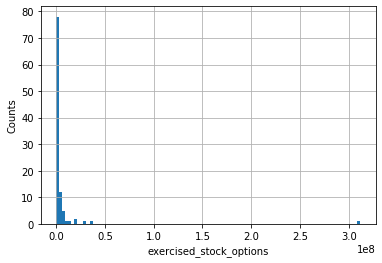

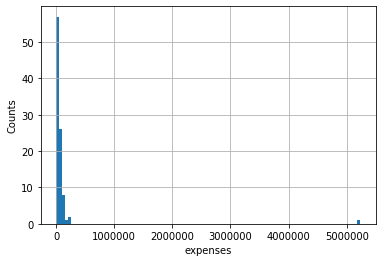

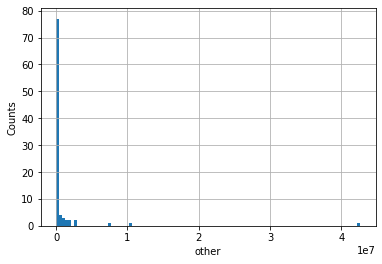

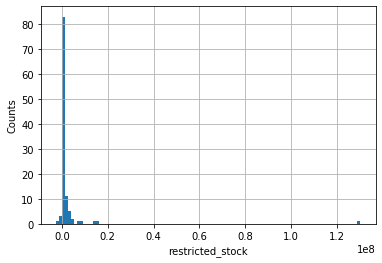

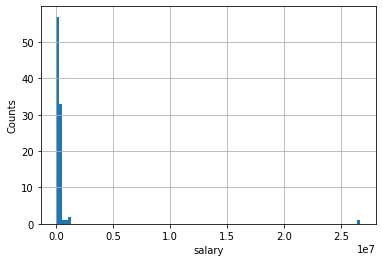

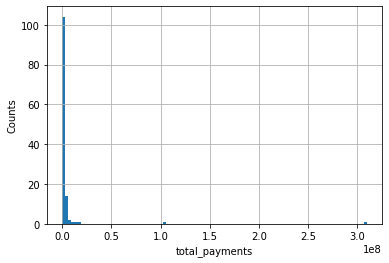

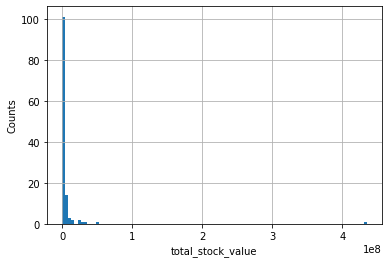

In [8]:
#畫出每個 Float Feature 的分布

ncols = 1;
nrows = len(float_features)
ind = 0
for f in float_features:
    plt.figure(num=ind)
    ind += 1
    s_tmp = df[f][(~df[f].isnull())] #拿非NaN 的來算統計    
    s_tmp.hist(bins = 100)
    plt.ylabel('Counts')
    plt.xlabel(f)
plt.show() 

### 處理 Outlier

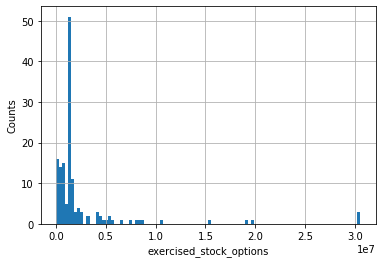

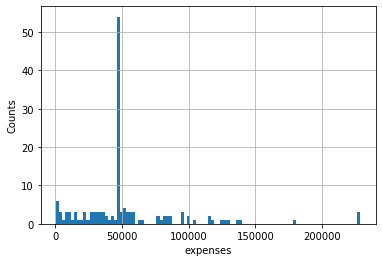

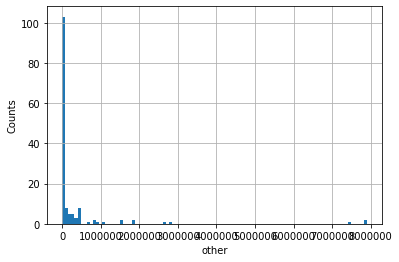

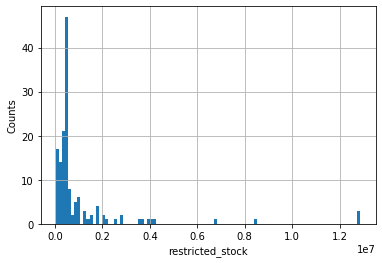

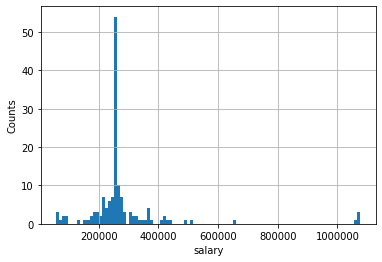

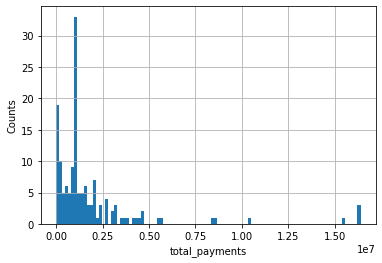

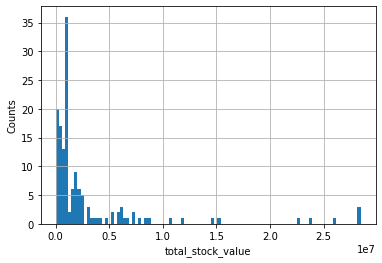

In [9]:
#對於每個 Float Feature 的分布，去除篇移值(用中位數替代)

ncols = 1;
nrows = len(float_features)
ind = 0
for f in float_features:
    plt.figure(num=ind)
    ind += 1
    s_tmp = df[f][(~df[f].isnull())] #拿非NaN 的來算統計
    md = s_tmp.median()
    mean = s_tmp.mean()
    new_series = df[f].copy()
    new_series[df[f].isnull()] = md #nan 值用中位數取代
#     new_series[df[f].isnull()] = mean #nan 值用mean取代

    
    thr_u = s_tmp.quantile(0.98) #upper 
    thr_l = s_tmp.quantile(0.02) #lower
    new_series[new_series>thr_u] = thr_u 
    new_series[new_series<thr_l] = thr_l

    
    
    new_series.hist(bins = 100)
    plt.ylabel('Counts')
    plt.xlabel(f)
    
    df[f] = new_series #將處理後的 Series 塞回去原本的 DataFrame
plt.show() 

In [10]:
df.head(10)

,email_address,exercised_stock_options,expenses,other,restricted_stock,salary,total_payments,total_stock_value
0,56,19794175.00,46950.0,174839.00,2748364.00,420636.00,505050.0,22542539.0
1,36,19250000.00,29336.0,22122.00,6843672.00,1076993.44,8682716.0,26093672.0
2,83,1624396.00,22884.0,1573324.00,869220.00,211844.00,2003885.0,2493616.0
3,73,1310813.50,118134.0,907502.00,985032.00,224305.00,2652612.0,985032.0
4,10,1310813.50,35818.0,486.00,126027.00,240189.00,1639297.0,126027.0
5,45,30546626.22,77978.0,2856.00,451740.00,259996.00,91093.0,28429868.0
6,98,8308552.00,53947.0,147950.00,3576206.00,158403.00,360300.0,11884758.0
7,111,1310813.50,16514.0,101740.00,698242.00,288542.00,1490344.0,698242.0
8,57,30546626.22,99832.0,7896758.28,12876278.02,1072321.00,16390334.8,28429868.0
9,4,384728.00,125978.0,200308.00,393818.00,274975.00,1272284.0,778546.0


### Traning  (baseline)
* Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### K-fold partition

In [12]:
# 13 = 3 + 3 + 3 + 4  (positive)
# 100 = 25 + 25 + 25 + 25 (negative)
# 建立 indicate set

ind_1 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(3):
    ind_1[i] = True;
for i in range(start_ind, start_ind+25):
    ind_1[i] = True
    
ind_2 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(3, 6):
    ind_2[i] = True;
for i in range(start_ind+25, start_ind+50):
    ind_2[i] = True;
    
ind_3 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(6, 9):
    ind_3[i] = True;
for i in range(start_ind+50, start_ind+75):
    ind_3[i] = True;

ind_4 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(9, 13):
    ind_4[i] = True;
for i in range(start_ind+75, start_ind+100):
    ind_4[i] = True;

In [13]:
indices = [ind_1, ind_2, ind_3, ind_4]
for i in range(len(indices)):
    print('i=%d \n'%i, indices[i])

i=0 
 [ True  True  True False False False False False False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
i=1 
 [False False False  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True 

In [14]:
# log_reg  = LogisticRegression(solver='newton-cg') #一直紅字，不收斂
log_reg = LogisticRegression(solver='lbfgs')

train_X = df[:train_num].values

# Cross Validation  (K-fold)
acc = 0
# 訓練模型
for i in range(len(indices)):
    train_ind = ~indices[i]
    test_ind = indices[i]
    train_X_i = train_X[train_ind]
    train_Y_i = train_Y[train_ind]
    log_reg.fit(train_X_i, train_Y_i)

    x_test_i = train_X[test_ind] #取 df 後半段為 test
    y_test_i = train_Y[test_ind]
    y_pred_i = log_reg.predict(x_test_i)
    acc_i = metrics.accuracy_score(y_test_i, y_pred_i)
    acc += acc_i/len(indices)
print("Accuracy: ", acc)

Accuracy:  0.8673029556650245


In [15]:
# #拿全部的資料來 Train
# log_reg.fit(train_X, train_Y)
# y_pred = log_reg.predict(train_X)
# acc = metrics.accuracy_score(y_pred, train_Y)
# print('acc = %.5f '%acc)


# test_X = df[train_num:].values
# #注意 logistic regression 的預測輸出，第一個column 是 0 的機率，第二個 column 是 1 的機率
# y_pred_prob = log_reg.predict_proba(test_X)[:, 0]

In [16]:
#拿四種 K-fold 的模型 所估計的機率取平均
test_X = df[train_num:].values

y_pred_prob_avg = np.zeros(len(test_X))
for i in range(len(indices)):
    train_ind = ~indices[i]
    test_ind = indices[i]
    train_X_i = train_X[train_ind]
    train_Y_i = train_Y[train_ind]
    log_reg.fit(train_X_i, train_Y_i)
    
    test_y_pred_i = log_reg.predict_proba(test_X)[:, 0]
    y_pred_prob_avg += test_y_pred_i/len(indices)


y_pred_prob = y_pred_prob_avg

### 建立Kaggle submission

In [17]:
submission_df = pd.DataFrame()
submission_df['name'] = df_test['name']
submission_df['poi'] = y_pred_prob
print(submission_df)

                    name       poi
0       BELDEN TIMOTHY N  0.756206
1     BOWEN JR RAYMOND M  0.855293
2         HANNON KEVIN P  0.761680
3       DELAINEY DAVID W  0.922698
4       CAUSEY RICHARD A  0.923500
5       HICKERSON GARY J  0.802566
6         FREVERT MARK A  0.997906
7            CHAN RONNIE  0.907794
8   DONAHUE JR JEFFREY M  0.949039
9      REYNOLDS LAWRENCE  0.494296
10      HORTON STANLEY C  0.714096
11         LEWIS RICHARD  0.900539
12    SHERRICK JEFFREY B  0.904713
13        MEYER JEROME J  0.822708
14   DERRICK JR. JAMES V  0.864154
15              PIRO JIM  0.862048
16   DETMERING TIMOTHY J  0.841228
17     KISHKILL JOSEPH G  0.830595
18        BAY FRANKLIN R  0.871997
19        PRENTICE JAMES  0.921539
20                 TOTAL  0.577500
21        FALLON JAMES B  0.931931
22            METTS MARK  0.953194
23         WODRASKA JOHN  0.906955
24   MORDAUNT KRISTINA M  0.853634
25      CARTER REBECCA C  0.900950
26      BHATNAGAR SANJAY  0.482167
27      WALTERS GARE

### 存檔成CSV

In [18]:
import time
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)

submission_filename = 'Result_'+time_str+'.csv'
submission_df.to_csv(submission_filename, index=False)

### public testing set
* Result_10-24T210049.csv  Score:0.5
* Result_10-24T210506.csv  Score:0.50714
* Result_10-24T210953.csv  Score:0.4
* Result_10-24T212633.csv  Score:0.57857
* Result_10-25T145901.csv  Score:0.61428
* Result_10-25T150316.csv  Score:0.55
* Result_10-25T151218.csv  Score:0.2785
* Result_10-25T152132.csv  Score:0.5857
* Result_10-26T142733.csv  Score:0.65
* Result_10-26T145526.csv  Score:0.67142
* Result_10-26T151128.csv  Score:0.43571
* Result_10-26T151718.csv  Score:0.67142
* Result_10-27T111757.csv  Score:0.5
* Result_10-27T112209.csv  Score:0.43